<h1><strong><u>Assignment 6 (SOM/MLP)</u></strong></h1>

In [3]:
pip install sklearn-som

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, silhouette_score, pair_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn_som.som import SOM

plt.style.use('dark_background')

%run DataCleaningFunctions.ipynb

<h2><strong><u>Data Preprocessing</u></strong></h2>

<h3><u>Data Loading</u></h3>

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/cdavidshaffer/CPSC4970-AI/master/data/penguins.csv")
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   species            344 non-null    object
 1   island             344 non-null    object
 2   culmen_length_mm   344 non-null    object
 3   culmen_depth_mm    344 non-null    object
 4   flipper_length_mm  344 non-null    object
 5   body_mass_g        344 non-null    object
 6   sex                344 non-null    object
dtypes: object(7)
memory usage: 18.9+ KB


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,?,?,?,?,?
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,FEMALE
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,MALE
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,?
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,?


<h3><u>Data Cleaning</u></h3>

In [6]:
# check text column unique values
textual_columns = ['species', 'island', 'sex']
print_unique_values(textual_columns, data)

['Adelie' 'Chinstrap' 'Gentoo']
['Torgersen' 'Biscoe' 'Dream']
['MALE' 'FEMALE' '?' '_']


In [7]:
# Replace invalid text entries
replace_characters = ['?', '_']

for char in replace_characters:
    replace_data_values(data, 'sex', char, None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   species            344 non-null    object
 1   island             344 non-null    object
 2   culmen_length_mm   344 non-null    object
 3   culmen_depth_mm    344 non-null    object
 4   flipper_length_mm  344 non-null    object
 5   body_mass_g        344 non-null    object
 6   sex                333 non-null    object
dtypes: object(7)
memory usage: 18.9+ KB


/var/folders/0_/nmh5w64x3q5_ffwfkr35sscw0000gn/T/ipykernel_37471/2898130538.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].replace(to_replace, value, inplace=True)


In [8]:
# convert text columns to string type
for i in textual_columns:
    data[i] = data[i].astype('string')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   species            344 non-null    string
 1   island             344 non-null    string
 2   culmen_length_mm   344 non-null    object
 3   culmen_depth_mm    344 non-null    object
 4   flipper_length_mm  344 non-null    object
 5   body_mass_g        344 non-null    object
 6   sex                333 non-null    string
dtypes: object(4), string(3)
memory usage: 18.9+ KB


In [9]:
# clean numerical columns from non-numerical values
numerical_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
check_numerical_column_errors(data, numerical_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    string 
 1   island             344 non-null    string 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    string 
dtypes: float64(4), string(3)
memory usage: 18.9 KB


In [10]:
# Drop all rows with missing values
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    string 
 1   island             333 non-null    string 
 2   culmen_length_mm   333 non-null    float64
 3   culmen_depth_mm    333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    string 
dtypes: float64(4), string(3)
memory usage: 20.8 KB


In [11]:
display(data)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [12]:
# checked data again after cleaning

# data.to_csv("penguins.csv", index=False, header=data.columns.tolist())

<h3><u>Data Preparation</u></h3>

In [13]:
X = data.drop("species", axis=1)
y = data["species"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(266, 6)

(67, 6)

(266,)

(67,)

In [22]:
# separate numerical and non-numerical data
X_train_nonnumerical = X_train.drop(columns=numerical_columns)
X_test_nonnumerical = X_test.drop(columns=numerical_columns)
display(X_train_nonnumerical.describe())
display(X_test_nonnumerical.describe())

X_train_numerical = X_train[numerical_columns]
X_test_numerical = X_test[numerical_columns]
display(X_train_numerical.describe())
display(X_test_numerical.describe())

,island,sex
count,266,266
unique,3,2
top,Biscoe,MALE
freq,130,138


,island,sex
count,67,67
unique,3,2
top,Biscoe,FEMALE
freq,33,37


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,266.000000,266.000000,266.00000,266.000000
mean,44.103008,17.161278,201.00000,4214.755639
std,5.404917,1.980538,13.91592,807.921183
min,32.100000,13.100000,172.00000,2700.000000
25%,39.600000,15.525000,190.00000,3550.000000
50%,45.100000,17.300000,197.00000,4050.000000
75%,48.575000,18.700000,213.00000,4800.000000
max,59.600000,21.500000,231.00000,6300.000000


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,67.000000,67.000000,67.000000,67.000000
mean,43.555224,17.179104,200.835821,4176.492537
std,5.735807,1.938332,14.511852,799.678920
min,34.600000,13.300000,178.000000,2900.000000
25%,38.400000,15.900000,190.000000,3550.000000
50%,43.300000,17.300000,196.000000,3950.000000
75%,48.800000,18.600000,212.500000,4700.000000
max,58.000000,21.100000,230.000000,5950.000000


<h3><u>Feature Engineering (SOM)</u></h3>

In [ ]:
som = SOM(m=5, n=5, dim=X_train_numerical.shape[1], random_state=42)
som.fit(X_train_numerical.values)
som_train_predictions = som.predict(X_train_numerical.values)
som_test_predictions = som.predict(X_test_numerical.values)
print(som_train_predictions)
print(som_test_predictions)

[14 16  3 17 23  9 19  8 18 23  1  6  4  5 18 15  6  4  8 23  8 13 10  4
  4 24 23 24 10 14 24 12  7 15  9 14  0 13  6  4  4  5  6 21 13 17  6 18
  6 16  2 22 10 23 16  8  0 17  8 21 22 18  0 21 18  0  6 21 21  4  7  8
  6  5  9 10 14 15  8  0  4  9 19  1 13 23 19  9 24 19 16 15 15 23  4  8
  8  5  9 14  7  4 15  5 17  4 16 14  4 13 15 16  0 14 18 14  4 18 20 14
  5  9 23 13 18 23  6 24 13 21 23 16  5 14 24  9 17 14  4 16 17 24 10 18
  3 23 21 23  4  5  9  6  3 14  3  6 10  4  3  1 14  7 21 23 18 12  6 24
  9  8  5  8 16 13 16  3  7  3  0 21 22  8 16 14  9  4 21 21  4  5 10 17
  0  2 17 13  8 19 19 14 19  0 12 14 19  4  4 18  5 24  7  4  6  2 13  6
 17  6 17  5 14  8 19 20  3 13 16 16  2  0  4 10  4  9 21 22  6  5  9  0
 17 20 21  8  3 22 11  4 19  3  4  8  5 15 23 22 19 13 18  3 17 22 23 15
  8 15]
[15  8 24  6 24 14  4  0  1 23 14 19 13  5 19 10 21  5 17 19 12  6  4 24
  0 21  9 14  6  4 21  4 19 22  4 13 17 23  5 21 16  5 10 23 16 22  3 18
 23  8  6  4 14  0 23  3 15 19 23 12  4  4 

In [69]:
X_train_nonnumerical_som = pd.DataFrame(np.append(X_train_nonnumerical, som_train_predictions.reshape(-1, 1), axis=1), columns=X_train_nonnumerical.columns.tolist() + ['SOM Category'])
X_test_nonnumerical_som = pd.DataFrame(np.append(X_test_nonnumerical, som_test_predictions.reshape(-1, 1), axis=1), columns=X_train_nonnumerical.columns.tolist() + ['SOM Category'])


display(X_train_nonnumerical_som.shape)
display(X_test_nonnumerical_som.shape)
display(X_train_nonnumerical_som.columns.tolist())
display(X_test_nonnumerical_som.columns.tolist())
display(X_train_nonnumerical_som.head(5))
display(X_test_nonnumerical_som.head(5))
preprocessor = make_column_transformer(
    (OneHotEncoder(), X_train_nonnumerical_som.columns.tolist()),
    remainder='passthrough'
)
X_train_processed = preprocessor.fit_transform(X_train_nonnumerical_som)
X_test_processed = preprocessor.transform(X_test_nonnumerical_som)
display(X_train_processed.shape)
display(X_test_processed.shape)


(266, 3)

(67, 3)

['island', 'sex', 'SOM Category']

['island', 'sex', 'SOM Category']

,island,sex,SOM Category
0,Biscoe,FEMALE,14
1,Dream,FEMALE,16
2,Biscoe,MALE,3
3,Biscoe,FEMALE,17
4,Biscoe,MALE,23


,island,sex,SOM Category
0,Dream,FEMALE,15
1,Biscoe,FEMALE,8
2,Torgersen,MALE,24
3,Dream,FEMALE,6
4,Biscoe,MALE,24


(266, 30)

(67, 30)

In [83]:
pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=2000, random_state=42)),
    ]
)

cv_params = {
    'clf__hidden_layer_sizes': [(50, 2), (100, 2), (150, 2)],
}
grid_search = GridSearchCV(pipeline, cv_params, cv=5, n_jobs=-1, scoring='accuracy', verbose=3)
grid_search.fit(X_train_processed, y_train)
best_model = grid_search.best_estimator_
display(best_model)
y_train_pred = best_model.predict(X_train_processed)
y_test_pred = best_model.predict(X_test_processed)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Training Accuracy after Hyperparameter Tuning: {train_accuracy:.4f}")
print(f"Testing Accuracy after Hyperparameter Tuning: {test_accuracy:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.868 total time=   0.3s
[CV 2/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.887 total time=   0.3s
[CV 5/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.755 total time=   0.3s
[CV 1/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.778 total time=   0.4s
[CV 1/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.759 total time=   0.4s
[CV 4/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.811 total time=   0.4s
[CV 3/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.717 total time=   0.4s
[CV 3/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.717 total time=   0.3s
[CV 4/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.774 total time=   0.2s
[CV 4/5] END ..clf__hidden_layer_sizes=(150, 2);, score=0.660 total time=   0.2s
[CV 5/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.811 total time=   0.3s
[CV 2/5] END ..clf__hidden_layer_sizes=(150, 2);,

Pipeline(steps=[('clf',
                 MLPClassifier(hidden_layer_sizes=(100, 2), max_iter=2000,
                               random_state=42))])

Best Hyperparameters: {'clf__hidden_layer_sizes': (100, 2)}
Training Accuracy after Hyperparameter Tuning: 0.8759
Testing Accuracy after Hyperparameter Tuning: 0.8657


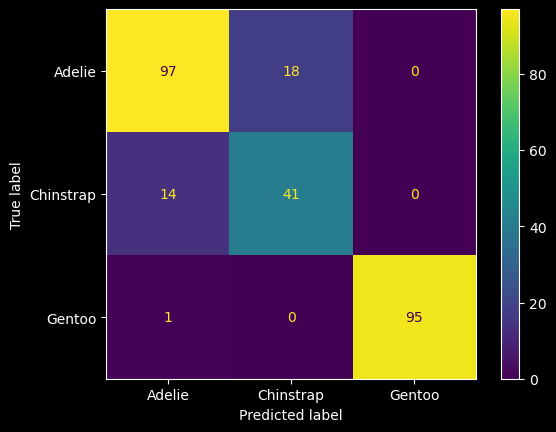

In [88]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

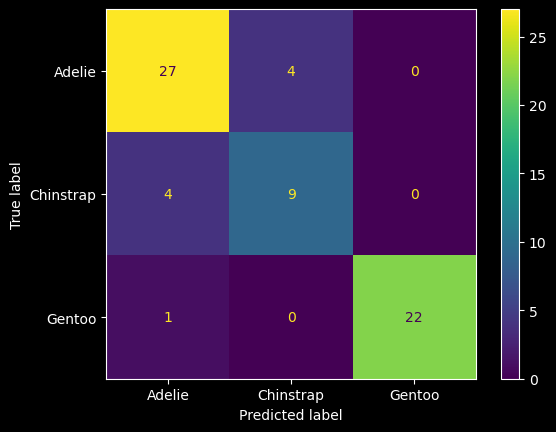

In [87]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)